In [2]:
import os
import sys
sys.path.append('..')

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import BertTokenizer
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.metrics import f1_score

from core.dataset import HatefulMemesDataset
from core.model import HateMemeModel, PretrainedModel

/Users/nstanishev/opt/anaconda3/envs/epfl-dl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = HatefulMemesDataset('/Users/nstanishev/Workspace/epfl/04/dl/project/data/data/train.jsonl')
val_dataset = HatefulMemesDataset('/Users/nstanishev/Workspace/epfl/04/dl/project/data/data/dev.jsonl')
test_dataset = HatefulMemesDataset('/Users/nstanishev/Workspace/epfl/04/dl/project/data/data/test.jsonl')

In [3]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8500, 500, 1000)

In [4]:
train_dataset[0]

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=265x400>,
 'its their character not their color that matters',
 0)

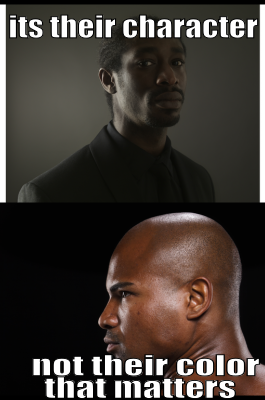

In [5]:
train_dataset[0][0]

In [6]:
transform = transforms.Compose([
    transforms.Resize((232, 232)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
max([len(el['text'].split(' ')) for el in train_dataset.data]), \
max([len(el['text'].split(' ')) for el in val_dataset.data]), \
max([len(el['text'].split(' ')) for el in test_dataset.data])

(70, 42, 57)

In [8]:
max([len(tokenizer(el['text'])['input_ids']) for el in train_dataset.data]), \
max([len(tokenizer(el['text'])['input_ids']) for el in val_dataset.data]), \
max([len(tokenizer(el['text'])['input_ids']) for el in test_dataset.data])

(88, 54, 74)

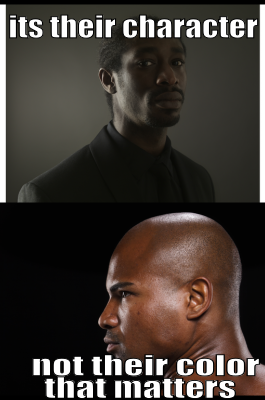

In [9]:
train_dataset[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


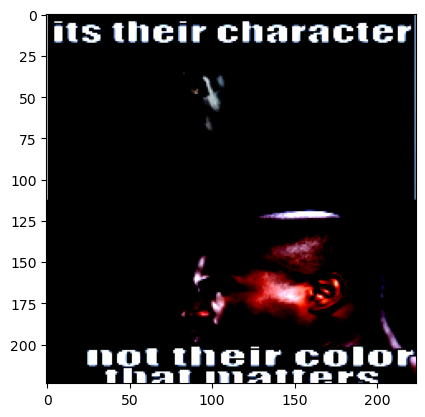

In [10]:
transform = transforms.Compose([
    transforms.Resize((232, 232)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
plt.imshow(transform(train_dataset[0][0]).permute(1, 2, 0))

In [11]:
img = Image.open(os.path.join(train_dataset.data_dir, train_dataset.data[8]['img']))
print(img.size)
transform = transforms.Compose([
    transforms.Resize((232, 232)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform(img).shape

(550, 366)


torch.Size([3, 224, 224])

In [12]:
img = Image.open(os.path.join(train_dataset.data_dir, train_dataset.data[9]['img']))
print(img.size)
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.Resize((232, 232)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform(img).shape

(177, 800)


torch.Size([3, 224, 224])

In [6]:
model = HateMemeModel(PretrainedModel.load_bert_text_model(), PretrainedModel.load_resnet_image_model())

/Users/nstanishev/opt/anaconda3/envs/epfl-dl/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nstanishev/opt/anaconda3/envs/epfl-dl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model

HateMemeModel(
  (text_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [9]:
img = transform(train_dataset[0][0])
text = tokenizer(train_dataset[0][1], return_tensors='pt')
label = torch.tensor(train_dataset[0][2])

In [10]:
PretrainedModel.load_bert_text_model()(**text).pooler_output.shape

torch.Size([1, 768])

In [11]:
image_features = PretrainedModel.load_resnet_image_model()(img.unsqueeze(0))
image_features.view(image_features.size(0), -1).shape

torch.Size([1, 2048])

In [12]:
model(text, img.unsqueeze(0))

tensor([[0.0332, 0.0183]], grad_fn=<AddmmBackward0>)

In [4]:
lr = 1e-5
epochs = 10
batch_size = 64

In [5]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.Resize((232, 232)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def collate_fn(batch):
    lens = [len(row[1]['input_ids'][0]) for row in batch]
    bsz, max_seq_len = len(batch), max(lens)

    input_ids_tensor = torch.zeros(bsz, max_seq_len).long()
    token_type_ids_tensor = torch.zeros(bsz, max_seq_len).long()
    attention_mask_tensor = torch.zeros(bsz, max_seq_len).long()

    image_tensor = torch.stack([row[0] for row in batch])

    label_tensor = torch.tensor([row[2] for row in batch])

    for i_batch, (input_row, length) in enumerate(zip(batch, lens)):
        input_ids_tensor[i_batch, :length] = input_row[1]['input_ids'][0]
        token_type_ids_tensor[i_batch, :length] = input_row[1]['token_type_ids'][0]
        attention_mask_tensor[i_batch, :length] = input_row[1]['attention_mask'][0]

    return image_tensor, {'input_ids': input_ids_tensor, 'token_type_ids': token_type_ids_tensor, 'attention_mask': attention_mask_tensor}, label_tensor


train_dataset = HatefulMemesDataset(
    '/Users/nstanishev/Workspace/epfl/04/dl/project/data/data/train.jsonl',
    tokenizer=tokenizer,
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataset = HatefulMemesDataset(
    '/Users/nstanishev/Workspace/epfl/04/dl/project/data/data/dev.jsonl',
    tokenizer=tokenizer,
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [6]:
model = HateMemeModel(PretrainedModel.load_bert_text_model(), PretrainedModel.load_resnet_image_model())
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/nstanishev/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:17<00:00, 5.95MB/s]


In [16]:
train_losses = []
for epoch in range(epochs):
    train_losses = []
    model.train()
    optimizer.zero_grad()

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        image, text, label = batch

        output = model(text, image)
        loss = criterion(output, label)

        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

  1%|          | 1/133 [01:31<3:21:10, 91.45s/it]


KeyboardInterrupt: 

In [11]:
with torch.no_grad():
    losses, preds, labels = [], [], []
    for batch in tqdm(val_loader):
        image, text, label = batch

        out = model(text, image)
        loss = criterion(out, label)
        losses.append(loss.item())

        pred = np.argmax(torch.sigmoid(out).cpu().detach().numpy(), axis=1)

        preds.append(pred.tolist())
        labels.append(label.cpu().numpy())

100%|██████████| 8/8 [02:15<00:00, 16.88s/it]


In [19]:
labels[:-1]

[array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1]),
 array([0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]),
 array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]),
 array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]),
 array([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1

In [30]:
l = np.concatenate(labels)
p = np.concatenate(preds)

In [33]:
f1_score(l, p, average='macro')

0.36896750821364155

In [8]:
metrics = {"loss": np.mean(losses)}
labels = np.vstack(labels)
preds = np.vstack(preds)
metrics["macro_f1"] = f1_score(labels, preds, average="macro")
metrics["micro_f1"] = f1_score(labels, preds, average="micro")

metrics

/Users/nstanishev/opt/anaconda3/envs/epfl-dl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'loss': 0.6931933164596558,
 'macro_f1': 0.484375,
 'micro_f1': 0.6666666666666666}